In [101]:
# !kaggle datasets download -d blastchar/telco-customer-churn
# !mv telco-customer-churn.zip data/ 
# !unzip data/telco-customer-churn.zip -d data/

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.model_selection import train_test_split


In [103]:
df = pd.read_csv("../03_classification/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)

(7043, 21)


In [104]:
df.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


## preprocess

In [105]:
# get feats name uniformity
df.columns = df.columns.str.lower().str.replace(" ", "_")
categoricals = list(df.dtypes[df.dtypes == "object"].index)
for c in categoricals:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# covert object 'totalcharges' to numeric
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

# encode target
df.churn = (df.churn == "yes").astype(int)

In [106]:
df_full_train, dfts = train_test_split(df, test_size=0.2, random_state=1)
dftr, dfvl = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(dftr.shape, dfvl.shape, dfts.shape)

dftr = dftr.reset_index(drop=True)
dfvl = dfvl.reset_index(drop=True)
dfts = dfts.reset_index(drop=True)

ytr = dftr.churn
yvl = dfvl.churn
yts = dfts.churn

del dftr["churn"]
del dfvl["churn"] 
del dfts["churn"]

(4225, 21) (1409, 21) (1409, 21)


In [107]:
# get features type
numerical = ['tenure','monthlycharges','totalcharges']
categorical = [x for x in df if (x not in numerical) & (x not in ['customerid', 'churn'])]

# encode catgoricals
train_dicts = dftr[categorical+numerical].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
xtr = dv.fit_transform(train_dicts)

val_dicts = dfvl[categorical+numerical].to_dict(orient="records")
xvl = dv.transform(val_dicts)

In [108]:
# fit & predict

model= LogisticRegression()
model.fit(xtr, ytr)

ypred = model.predict_proba(xvl)[:,1]
churn_decision = (ypred >= 0.5)
(yvl == churn_decision).mean()

0.8034066713981547

In [109]:
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    score = accuracy_score(yvl, ypred >= t)
    scores.append(score)
    print("%.2f %.3f" % (t, score))

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


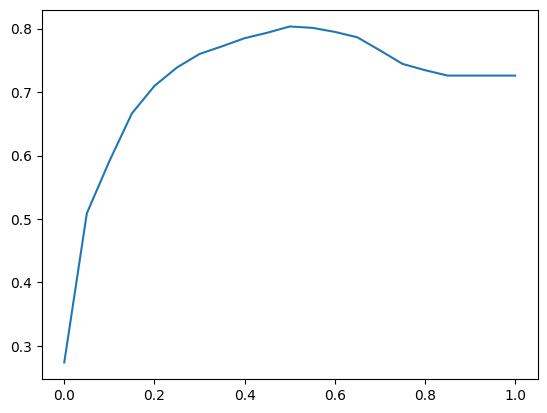

In [110]:
plt.plot(thresholds, scores);

## confusion matrix

In [111]:
actual_positive = (yvl == 1)
actual_negative = (yvl == 0)

t = 0.5
predict_positive = (ypred >= t)
predict_negative = (ypred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [112]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## precision / recall

In [113]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(accuracy)

0.8034066713981547


In [114]:
precision = tp / (tp + fp)
print(precision)
# how many positive predictions are correct

0.6752411575562701


In [115]:
recall = tp / (tp+fn)
print(recall)
# fraction of correctly identified positive examples

0.5440414507772021


## ROC curve

In [116]:
tpr = tp / (tp+fn)
fpr = fp / (fp+tn)
print(tpr, fpr)

0.5440414507772021 0.09872922776148582


In [55]:
def tpr_fpr_df(yvl, ypred):
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        actual_positive = (yvl == 1)
        actual_negative = (yvl == 0)
    
        predict_positive = (ypred >= t)
        predict_negative = (ypred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df = pd.DataFrame(scores, columns=columns)

    df["tpr"] = df.tp / (df.tp + df.fn)
    df["fpr"] = df.fp / (df.fp + df.tn)

    return df

df = tpr_fpr_df(yvl, ypred)
df[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


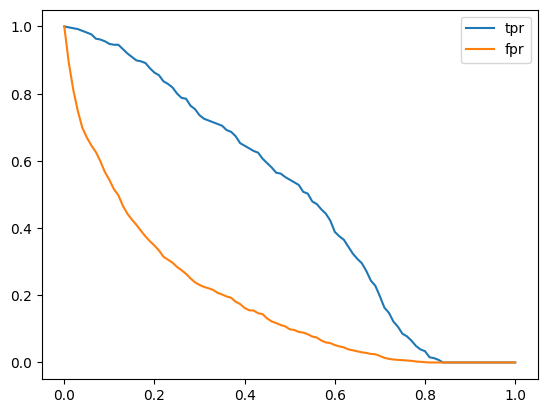

In [47]:
plt.plot(df.threshold, df.tpr, label="tpr")
plt.plot(df.threshold, df.fpr, label="fpr")
plt.legend();

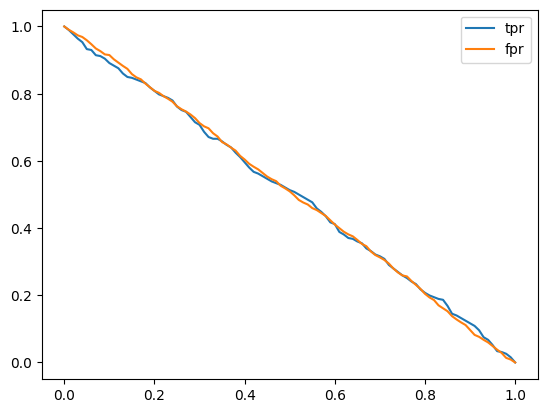

In [58]:
# random model
yrand = np.random.uniform(0, 1, size=len(yvl))
((yrand >= 0.5) == yvl).mean()

df_rand = tpr_fpr_df(yvl, yrand)

plt.plot(df_rand.threshold, df_rand.tpr, label="tpr")
plt.plot(df_rand.threshold, df_rand.fpr, label="fpr")
plt.legend();

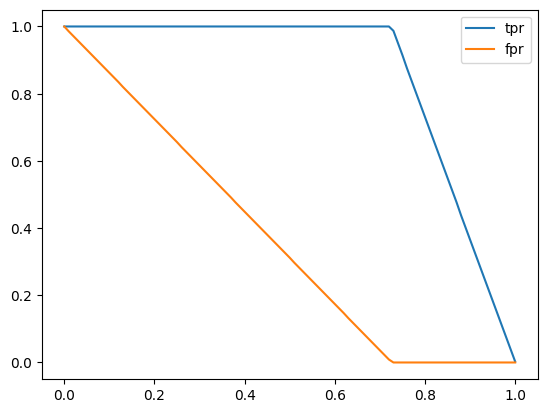

In [62]:
# ideal model
num_neg = (yvl == 0).sum()
num_pos = (yvl == 1).sum()

yideal = np.repeat([0, 1], [num_neg, num_pos])
yideal_pred = np.linspace(0,1,len(yvl))
((yideal_pred >= 0.7261) == yideal).mean()

df_ideal = tpr_fpr_df(yideal, yideal_pred)

plt.plot(df_ideal.threshold, df_ideal.tpr, label="tpr")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="fpr")
plt.legend();

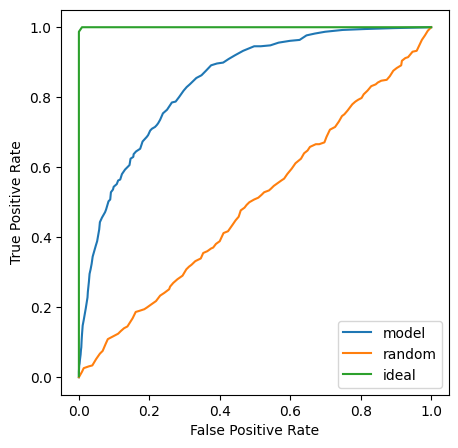

In [66]:
plt.figure(figsize=(5,5))
plt.plot(df.fpr, df.tpr, label="model")
plt.plot(df_rand.fpr, df_rand.tpr, label="random")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend();

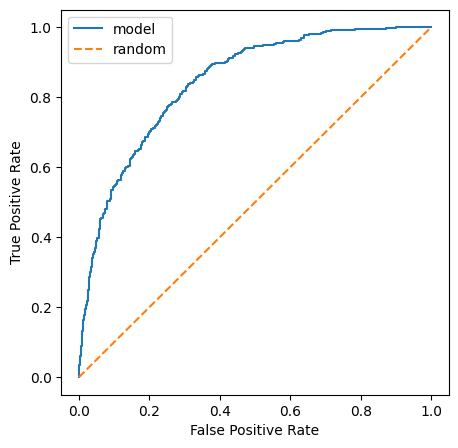

In [67]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(yvl, ypred)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label="model")
plt.plot([0,1], [0,1], label="random", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend();

## ROC AUC

In [70]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.843850505725819

In [73]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [74]:
fpr, tpr, thresholds = roc_curve(yvl, ypred)
auc(fpr, tpr)

0.843850505725819

In [75]:
from sklearn.metrics import roc_auc_score
roc_auc_score(yvl, ypred)

0.843850505725819

In [ ]:
# auc is telling what is the prob that randomly selected positive example
# has a score that is higher than the score of randomly selected negative example

In [79]:
import random 

n= 10000
success = 0


for i in range(n):
    neg = ypred[yvl == 0]
    pos = ypred[yvl == 1]

    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(pos)-1)

    if pos[pos_ind] > neg[neg_ind]:
        success += 1

success / n

0.8433

## cross-validation

In [96]:
def train(df, ytr, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    xtr = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(xtr, ytr)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    x = dv.transform(dicts)
    ypred = model.predict_proba(x)[:, 1]

    return ypred

dv, model = train(dftr, ytr)
ypred = predict(dfvl, dv, model)

In [97]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10,  shuffle=True, random_state=1)

train_idx, val_idx = next(kfold.split(df_full_train))
print(len(train_idx), len(val_idx))

5070 564


In [100]:
from tqdm.auto import tqdm

for C in [0.001, 0.01, 0.1, 1, 10]:

    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        
        dftr = df_full_train.iloc[train_idx]
        dfvl = df_full_train.iloc[val_idx]

        ytr = dftr.churn.values
        yvl = dfvl.churn.values

        dv, model = train(dftr, ytr, C)
        ypred = predict(dfvl, dv, model)

        auc = roc_auc_score(yvl, ypred)
        scores.append(auc)
    
    print("%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.001 0.826 +- 0.012


0it [00:00, ?it/s]

0.01 0.841 +- 0.012


0it [00:00, ?it/s]

0.1 0.841 +- 0.012


0it [00:00, ?it/s]

1 0.840 +- 0.013


0it [00:00, ?it/s]

10 0.841 +- 0.012


0.841 +- 0.012
